<a href="https://colab.research.google.com/github/MShiloni22/DDBMS_Project_B/blob/master/DDBMS_Project_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 62.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b7235ed68aa9d06e90a82cc2258ef70ccc0017096b0cec7cbd6b2e2cbf8d5218
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import findspark
import datetime as dt

findspark.init()
from pyspark.sql import SparkSession
def init_spark(app_name: str):
 spark = SparkSession.builder.appName(app_name).getOrCreate()
 sc = spark.sparkContext
 return spark, sc
spark, sc = init_spark('demo')
sc

<SparkContext master=local[*] appName=demo>

+-------------+-------------------+--------+-----+------+----+-----+-------------+-------------+-------------+
| Arrival_Time|      Creation_Time|  Device|Index| Model|User|   gt|            x|            y|            z|
+-------------+-------------------+--------+-----+------+----+-----+-------------+-------------+-------------+
|1424686735175|1424686733176178965|nexus4_1|   35|nexus4|   g|stand| 0.0014038086|    5.0354E-4|-0.0124053955|
|1424686735378|1424686733382813486|nexus4_1|   76|nexus4|   g|stand|-0.0039367676|  0.026138306|  -0.01133728|
|1424686735577|1424686733579072031|nexus4_1|  115|nexus4|   g|stand|  0.003540039| -0.034744263| -0.019882202|
|1424686735779|1424688581834321412|nexus4_2|  163|nexus4|   g|stand|  0.002822876|  0.005584717|  0.017318726|
|1424686735982|1424688582035859498|nexus4_2|  203|nexus4|   g|stand| 0.0017547607| -0.018981934| -0.022201538|
|1424686736186|1424686734188508066|nexus4_1|  236|nexus4|   g|stand| 0.0014038086|  0.010116577|  4.119873E-4|
|

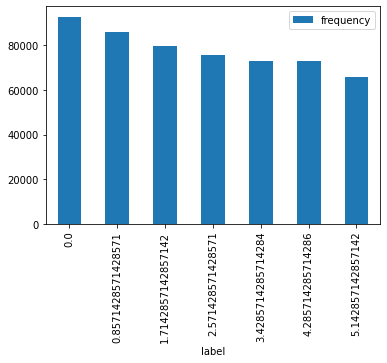

In [ ]:
# Section 1 - Data Analysis
import pandas as pd
import pyspark.sql as sparksql
from pyspark.ml.feature import StringIndexer
import pyspark.sql.functions as F

# Read JSON file into dataframe
df = spark.read.json("/content/drive/MyDrive/Colab Files/DDBMS/data.json")
df.show()

# convert categorical values of 'gt' to indices
indexer = StringIndexer(
  inputCols=["Device", "Model", "User", "gt"],
  outputCols=["Device_index", "Model_index", "User_index", "label"])
model = indexer.fit(df)
df = model.transform(df)
df.show()

## insight 1 - histogram of gt values and their propotion#
# creating hist in spark df
gt_histogram = df.select('label').rdd.flatMap(lambda x: x).histogram(7)

# convert hist to pandas, in order to plot
pd.DataFrame(
    list(zip(*gt_histogram)), 
    columns=['label', 'frequency']
).set_index(
    'label'
).plot(kind='bar')
# Insight 1:
# We can see that the different clusters of activities are balanced, more or less
# Therefore, we can avoid scaling weighting when we approach the label classification

## insight 2 - can arrival\creation time can be ignored? ##
# convert creation_time to arrival's format
df = df.withColumn("arrival_creation_diff",
                   F.col("Arrival_Time")**2 - (F.col("Creation_Time")%1000000)**2)
df.show()
	
# mean and variance value of the column in pyspark
df.agg({'arrival_creation_diff': 'mean'}).show()
df.agg({'arrival_creation_diff': 'variance'}).show()
# Insight 2:
# the mean difference between creation and arrival time is approximately 2 seconds
# the variance is approx. 1 second
# therefore, we can ignore one of these columns in the ML process, we chose
# to continue with Arrival_Time


